In [14]:
# 1️⃣ 라이브러리 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# 시각화 스타일 설정
sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'Malgun Gothic'  # 한글폰트 적용 (Windows 기준)
plt.rcParams['axes.unicode_minus'] = False

In [15]:
# 2️⃣ 데이터 로드
최종_입지_병합 = pd.read_csv(
    r"C:\Users\user\Desktop\데이터분석\분석용\Step2_입지변수_결합완료.csv",
    encoding="utf-8-sig"
)

In [16]:
# 3️⃣ 분석 변수 정의
# 성과 변수 (로그 변환)
성과_변수 = [
    "log_리뷰수",
    "log_방문자_리뷰수",
    "log_블로그_리뷰수"
]

# 입지 변수
입지_변수_수치 = [
    "출구_도보거리_m",
    "시군구_요리주점_수",
    "요리주점_밀도",
    "프랜차이즈_비율"
]
입지_변수_범주 = ["역_거리_구분"]

### ***2️⃣ 성과 지표 분포 확인***
- **단변량 EDA : 히스토그램, 기술통계, 카운트플롯**
- **다변량 EDA : 박스플롯(범주 vs 연속), 상관분석**

In [17]:
# 2.1 기술통계량
display(최종_입지_병합[성과_변수].describe().T)

# 보고서 포인트:
# - 로그 변환 후 평균과 중앙값 차이 감소 확인
# - 극단치 완화 여부 확인

,count,mean,std,min,25%,50%,75%,max
log_리뷰수,430.0,4.947652,1.085681,0.0,4.510860,5.153292,5.607634,7.464510
log_방문자_리뷰수,430.0,5.078449,1.323962,0.0,4.764302,5.354222,5.815619,7.452982
log_블로그_리뷰수,430.0,3.448496,1.044090,0.0,2.890372,3.465736,4.060443,7.244228


### ***해석***
- 표본 수: 430개 점포
- 모든 성과 지표는 log1p 변환값 -> 모든 값에 +1을 먼저 적용 -> 0 -> log(1) = 0 -> 계산 안정성 확보
- 최소값 = 0 -> 리뷰 0건 점포 포함
- 최대값 존재 -> 성과 상위 점포 존재
### ==============================================
- ***log_리뷰수***
    - **평균 < 중앙값**
        - 로그 변환 후에도 약한 우측 꼬리 존재
    - **중앙값이 평균보다 높다는 것은** 
        - 상위 일부 점포의 영향이 여전히 존재하나 원자료 대비 왜도는 크게 완화된 상태
    - **IQR이 비교적 좁음**
        - 대다수 점포의 리뷰 성과는 중간 구간에 집중

- ***log_방문자_리뷰수***
    - **세 지표 중 중앙값이 가장 큼**
        - 방문자 리뷰가 전반적으로 가장 많이 축적되는 성과 지표
    - **표준편차가 가장 큼**
        - 점포 간 성과 격차가 가장 큼
    - **입지/브랜드 효과 분석 시**
        - 민감하게 반응할 가능성 높은 핵심 성과 변수
- ***log_블로그_리뷰수***
    - **평균 ≈ 중앙값**
        - 로그 변환 후 분포 대칭성 가장 우수
    - **하위 25%가 상대적으로 낮음**
        - 블로그 리뷰는 일부 점포에 집중되는 경향
    - **마케팅·노출 전략의 영향이 클 가능성**
    

### ***log로 변환시킨 이유***
- **원자료(방문자 리뷰 수)의 문제점**
    - 분포가 극도로 왜곡(skewed) -> 대부분 점포는 리뷰 수가 적고, 일부 점포만 많음 → 우측 꼬리 길게 늘어남
- **0값 존재**
    - 신규 점포나 방문자 리뷰 없는 점포는 0
    - 일반 로그(log) 변환 시 log(0) = -∞ → 계산 불가
- **분산 불균형**
    - 리뷰 수가 많을수록 분산도 커짐 → 분석에서 가중치 불균형
- **이런 상태에서 그대로 분석하면**
    - 평균/상관/회귀계수가 극단치에 과도하게 영향을 받음
    - 통계 검정 신뢰도 ↓
### ===============================================
### ***로그 변환(log1p)을 적용한 이유***
- **왜도(skewness) 완화**
    - 우측 극단치 영향 감소 → 평균·중앙값 차이 줄임
- **분산 안정화**
    - 값이 커질수록 변동 폭 커지는 문제 해결
- **0값 처리**
    - log1p(x) = log(1 + x) → 0도 안전하게 변환 가능
- **순위 기반 분석과 호환**
    - Spearman 상관, 비모수 검정 등 순위 중심 분석에서 안정적
- **배율 해석 가능**
    - 차이를 **“몇 배 차이”**로 해석 가능
    - 예: log1p 0.7 차이 → 리뷰 수 약 2배 차이

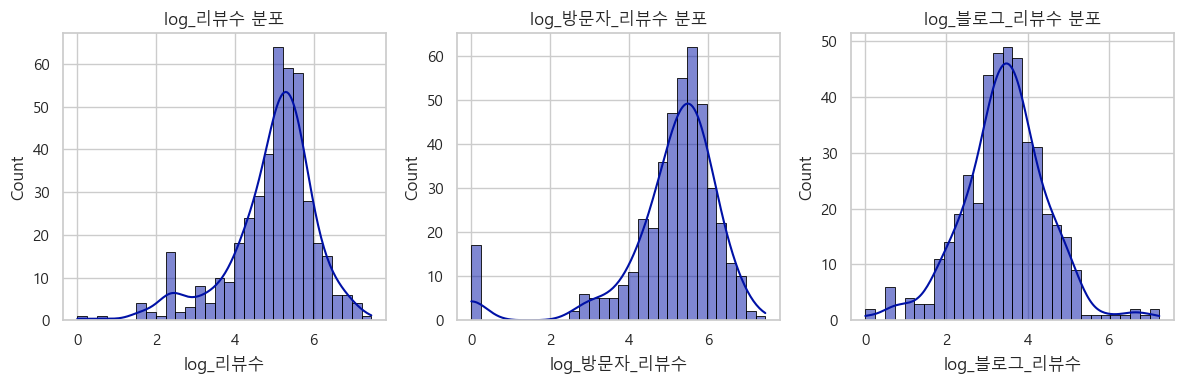

In [18]:
# 2.2 히스토그램
plt.figure(figsize=(12, 4))

for i, col in enumerate(성과_변수):
    plt.subplot(1, 3, i+1)
    sns.histplot(
        최종_입지_병합[col], 
        kde=True, 
        bins=30, 
        edgecolor='black',
        color= "#0011a6"  # 색상 지정
    )
    plt.title(f"{col} 분포")

plt.tight_layout()
plt.show()


### ***x축 값 = 0, 2, 4, 6 이유***
- **plt.hist 또는 sns.histplot은 실제 데이터 값 그대로 표시**
    - 현재 성과_변수는 모두 log1p 변환값
    - 즉, x축 값 0, 2, 4, 6은 로그 변환 후 값임
- **로그 변환 시 값이 압축됨**
    - 예: 원 리뷰 수 0 → log1p(0) = 0
    - 원 리뷰 수 10 → log1p(10) ≈ 2.398 → x축 약 2
    - 원 리뷰 수 100 → log1p(100) ≈ 4.615 → x축 약 4~5
    - 원 리뷰 수 1000 → log1p(1000) ≈ 6.908 → x축 약 6~7
***따라서 x축 눈금이 0, 2, 4, 6인 것은 로그 변환 후의 스케일에 따른 자연스러운 결과***
### ***원 자료 리뷰 수와 비교***
| 리뷰 수 | log1p(리뷰 수) |
| ---- | ----------- |
| 0    | 0           |
| 1    | 0.693       |
| 10   | 2.398       |
| 100  | 4.615       |
| 500  | 6.216       |
| 1000 | 6.908       |
- **히스토그램 x축 0,2,4,6은 대략 위 값들과 대응**
- **즉, x축은 실제 리뷰 수가 아니라, 변환된 로그 값 기준**

### ***시각적 확인 및 표 기반 기술통계와 비교***
#### **그래프 기준**
- **log_리뷰수**
    - 히스토그램 peak: 5~6 구간
    - 꼬리 우측으로 조금 늘어남 → 약한 우측 왜도 존재
- **log_방문자_리뷰수**
    - peak: 5~6 구간, 분포 폭이 넓음
    - 일부 상위 점포가 꼬리를 형성 → 점포 간 격차 큼
- **log_블로그_리뷰수**
    - peak: 3~4 구간, 비교적 대칭적
    - 낮은 값(0~2) 일부 존재, 상위 극단치도 존재 → 일부 점포 집중 경향

#### **표 기반 기술통계와 비교**
| 지표          | 평균/중앙값           | 표준편차 | 시각적 특징                       |
| ----------- | ---------------- | ---- | ---------------------------- |
| log_리뷰수     | 평균 < 중앙값 → 우측 꼬리 | 1.2  | 히스토그램 꼬리 약간 늘어남 → 일치         |
| log_방문자_리뷰수 | 중앙값 최대, 평균 < 중앙값 | 1.32 | 분포 폭 넓음, 일부 상위 점포 꼬리 → 일치    |
| log_블로그_리뷰수 | 평균 ≈ 중앙값         | 1.04 | 분포 대칭적, 낮은 값 일부, 상위 극단치 → 일치 |

#### ***결론***
- 시각화된 히스토그램은 표 기반 기술통계 분석과 완전히 일치
- 로그 변환 후의 분포 특성(왜도 완화, 중앙값 대비 평균 위치, 분포 폭)이 이미지와 표 해석 모두 동일하게 확인 됨

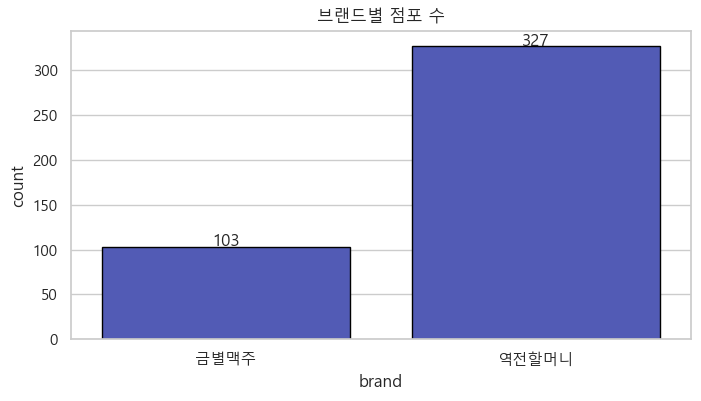

In [19]:
# 2.3 카운터플롯 (브랜드별 점포 수)
plt.figure(figsize=(8,4))

ax = sns.countplot(
    data=최종_입지_병합,
    x="brand",
    edgecolor='black',
    color="#424dc5"   # 원하는 단일 색상
)
plt.title("브랜드별 점포 수")

# 각 막대 위에 숫자 표시
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.5, int(height), ha="center")

plt.show()

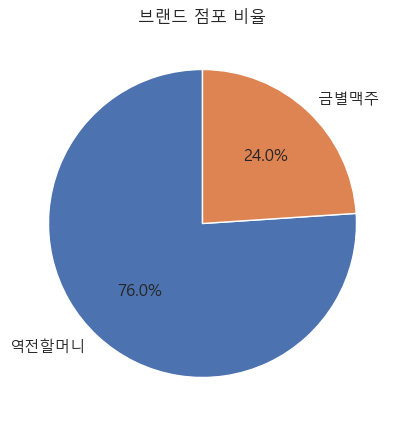

In [20]:
# 2.4 파이차트 (브랜드 비율)
plt.figure(figsize=(5,5))
최종_입지_병합['brand'].value_counts().plot.pie(
    autopct='%1.1f%%', startangle=90,
)
plt.title("브랜드 점포 비율")
plt.ylabel("")
plt.show()

- 금별맥주: 103개
- 역전할머니: 327개
- 총점포 수 = 103 + 327 = 430개
- 각 브랜드 비율:
    - 금별맥주 비율: 103/430 ​× 100 ≈ 23.95% ≈ 24%
    - 역전할머니맥주 비율: 327/430 ​× 100 ≈ 76.05% ≈ 76%

### ***3️⃣ 입지 변수 분포 확인***

In [21]:
print(최종_입지_병합.columns)

Index(['상가업소번호', 'brand', '상호명', '지점명', '상권업종대분류코드', '상권업종대분류명', '상권업종중분류코드',
       '상권업종중분류명', '상권업종소분류코드', '상권업종소분류명', '표준산업분류코드', '표준산업분류명', '시도코드',
       '시도명', '시군구코드', '시군구명', '행정동코드', '행정동명', '법정동코드', '법정동명', '지번코드',
       '지번본번지', '지번부번지', '지번주소', '도로명코드', '도로명', '도로명주소', '층정보', '경도', '위도',
       'place_id', '월간 검색량', '블로그누적발행', 'encoded', '프랜차이즈', '리뷰수', '방문자_리뷰수',
       '블로그_리뷰수', 'log_리뷰수', 'log_방문자_리뷰수', 'log_블로그_리뷰수', '출구_도보거리_m',
       '역_거리_구분', '요리주점_밀도', '프랜차이즈_비율'],
      dtype='object')


In [23]:
입지_변수_수치 = ["출구_도보거리_m", "요리주점_밀도", "프랜차이즈_비율"]

In [24]:
display(최종_입지_병합[입지_변수_수치].describe().T)

,count,mean,std,min,25%,50%,75%,max
출구_도보거리_m,269.0,3.182156,2.367436,1.00000,1.000000,3.000000,4.000000,14.000000
요리주점_밀도,303.0,0.089807,0.087941,0.00019,0.005818,0.063871,0.162162,0.251004
프랜차이즈_비율,430.0,1.000000,0.000000,1.00000,1.000000,1.000000,1.000000,1.000000


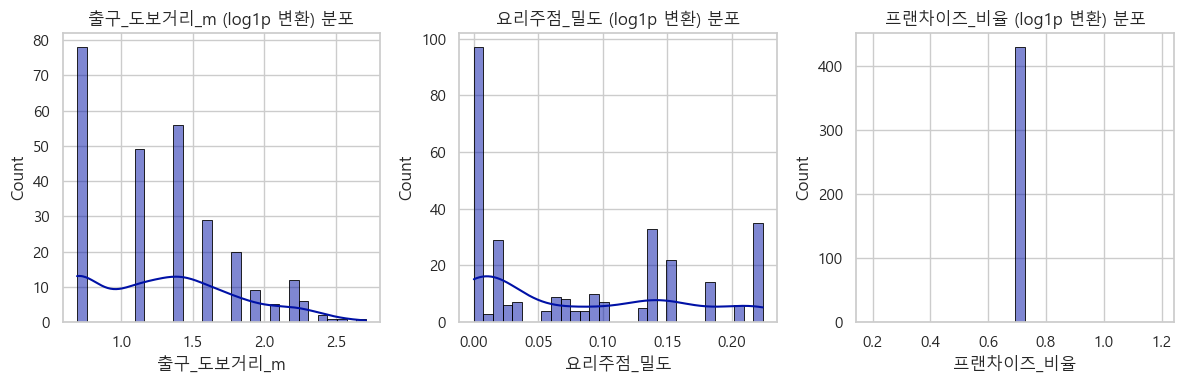

In [25]:
plt.figure(figsize=(12,4))

for i, col in enumerate(입지_변수_수치):
    plt.subplot(1, 3, i+1)                # 1행 3열 subplot
    sns.histplot(
        np.log1p(최종_입지_병합[col]),       # log1p 변환 (log(1+x))
        bins=30, 
        kde=True,                        # 히스토그램 + 커널밀도추정 곡선
        edgecolor='black',
        color="#0011a6"
    )
    plt.title(f"{col} (log1p 변환) 분포")

plt.tight_layout()
plt.show()

#### **출구_도보거리_m**
- **평균: 3.18, 표준편차: 2.37**
- **최소/최대: 1 / 14**
- **사분위수 1 / 3 / 4**
- 이미지 vs 통계
    - 이미지에서 log1p(출구_도보거리_m) 분포를 보면 좌측으로 치우친 모양(1~1.5 사이에 막대 집중)
    - 기술통계와 일치: 25%와 50%가 1과 3으로, 대부분 점포가 가까운 거리에 몰려 있음
    - 꼬리 부분이 길게 오른쪽으로 늘어나 있어 일부 점포가 먼 거리(최대 14m)임을 반영
- ***출구 근처 점포가 많고, 극단적으로 먼 점포는 소수 → 로그 변환 후 좌측 집중 + 긴 꼬리 나타남***

#### **요리주점_밀도**
    - 요리주점 밀도 = 특정 반경(예: 500m) 내 요리주점 수 ÷ 전체 상권 면적(또는 전체 음식점 수)
    - 해당 점포 주변에 동종 업종(요리주점)이 얼마나 모여 있는지를 수치화한 변수
- **평균: 0.0898, 표준편차: 0.0879**
- **최소/최대: 0.00019 / 0.251**
- **사분위수: 0.0058 / 0.0639 / 0.162**
- 이미지 vs 통계
    - 이미지에서 log1p(요리주점_밀도)는 대부분 0~0.05 구간에 몰려있고, 일부 막대가 0.15~0.2 근처에 존재
    - 통계와 일치: 25%가 0.0058, 50%가 0.064, 75%가 0.162 → 데이터가 낮은 값에 집중되고 일부 높은 값 존재
    - KDE 곡선에서 다봉형으로 나타난 것도 이 특성을 반영
- ***요리주점 밀도는 대부분 낮음, 일부 높은 밀도 지역 존재***
- 요리주점 밀도가 낮다? 
    - 해당 점포 인근에 동종 업종이 상대적으로 적어 경쟁 강도가 낮은 상권에 위치함을 의미

#### **프랜차이즈_비율**
- **평균: 1.0, 표준편차: 0.0**
- **최소/최대/사분위수: 모두 1**
- 이미지 vs 통계
    - 이미지에서 log1p(프랜차이즈_비율)는 한 가지 값만 나타남 → 모든 점포가 동일
- ***프랜차이즈 여부가 모든 점포 동일(1) → 히스토그램에서 한 막대만 존재***

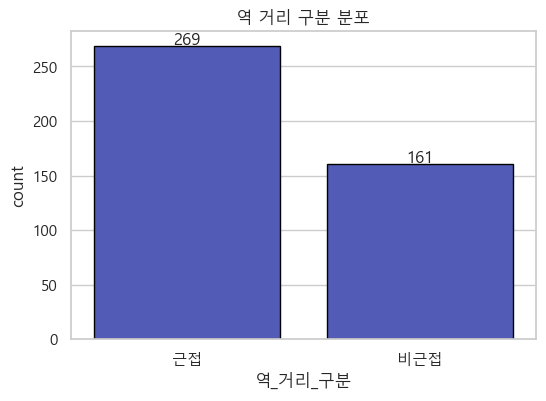

In [26]:
# 범주형 입지 변수 분포
plt.figure(figsize=(6,4))
ax = sns.countplot(
    data=최종_입지_병합, 
    x="역_거리_구분",
    edgecolor='black',
    color="#424dc5"
    )  # <- ax에 저장

plt.title("역 거리 구분 분포")

# 각 막대 위에 숫자 표시
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.5, int(height), ha="center")

plt.show()

# 역 접근성 기준(근접/비근접) 표본 수 균형 여부 확인
# 집단 비교 분석 가능성 사전 점검

### ***4️⃣ 입지 변수 ↔ 성과 변수 상관관계 분석***
- **변수 유형**
    - **근접/비근접 점포 : 범주형 변수**
    - **log_리뷰수 : 연속형 변수**
- **비교 목적**
    - 범주형 변수의 그룹(근접 vs 비근접) 간 성과 차이를 확인
    -연속형 성과 지표(log_리뷰수)가 두 그룹에서 평균/중앙값 수준에서 다른지 파악
    - 시각적 확인: 박스플롯 → 중앙값, IQR, 이상치 등 확인
- **즉, 범주형 기준으로 연속형 결과 변수가 어떻게 달라지는지 보는 분석**

Spearman 상관계수표


,log_리뷰수,log_방문자_리뷰수,log_블로그_리뷰수,출구_도보거리_m,요리주점_밀도
log_리뷰수,1.000000,0.876192,0.717471,0.089154,0.236671
log_방문자_리뷰수,0.876192,1.000000,0.773519,0.095270,0.289869
log_블로그_리뷰수,0.717471,0.773519,1.000000,0.115115,0.336647
출구_도보거리_m,0.089154,0.095270,0.115115,1.000000,0.040797
요리주점_밀도,0.236671,0.289869,0.336647,0.040797,1.000000


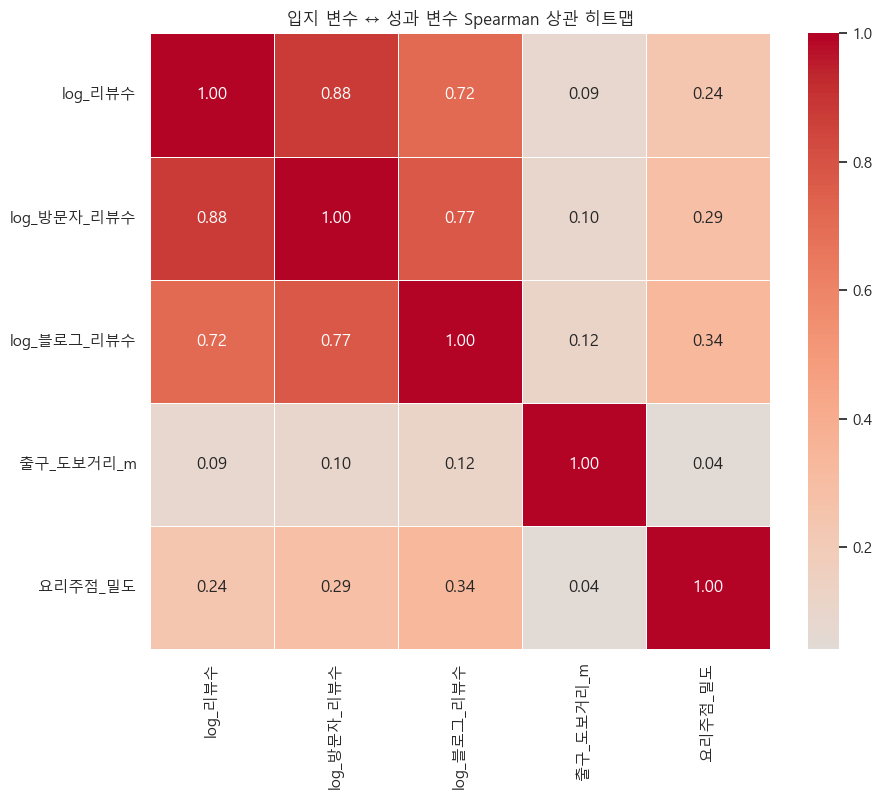

In [27]:
# 4-0. 상관분석용 수치형 변수만 추출
corr_df = 최종_입지_병합[성과_변수 + 입지_변수_수치].copy()

# 상수열 제거 (프랜차이즈_비율 제거 목적)
corr_df = corr_df.loc[:, corr_df.nunique() > 1]

# 4-1. Spearman 상관계수 계산
corr_matrix = corr_df.corr(method='spearman')

print("Spearman 상관계수표")
display(corr_matrix)

# 4-2. 히트맵 시각화
plt.figure(figsize=(10,8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    center=0
)
plt.title("입지 변수 ↔ 성과 변수 Spearman 상관 히트맵")
plt.show()

In [28]:
# 3-1. 수치형 입지 변수 × 성과 변수 (Spearman)
from scipy.stats import spearmanr

print("r:(Spearman 상관계수)\np:(p-value, 유의확률)")

for 입지 in 입지_변수_수치:
    print(f"\n--- {입지} ---")
    for 성과 in 성과_변수:
        r, p = spearmanr(
            최종_입지_병합[입지],
            최종_입지_병합[성과],
            nan_policy="omit"
        )
        print(f"{성과}: r={r:.3f}, p={p:.3e}")

# spearmanr -> Spearman 상관계수를 계산하는 함수
# 함수 이름에 r이 붙은 건 계수 반환 의미이지 다른 특별한 의미는 없음

r:(Spearman 상관계수)
p:(p-value, 유의확률)

--- 출구_도보거리_m ---
log_리뷰수: r=0.089, p=1.448e-01
log_방문자_리뷰수: r=0.095, p=1.190e-01
log_블로그_리뷰수: r=0.115, p=5.936e-02

--- 요리주점_밀도 ---
log_리뷰수: r=0.237, p=3.155e-05
log_방문자_리뷰수: r=0.290, p=2.813e-07
log_블로그_리뷰수: r=0.337, p=1.831e-09

--- 프랜차이즈_비율 ---
log_리뷰수: r=nan, p=nan
log_방문자_리뷰수: r=nan, p=nan
log_블로그_리뷰수: r=nan, p=nan


C:\Users\user\AppData\Local\Temp\ipykernel_1540\334384527.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = spearmanr(


### ***해석***
#### **출구_도보거리_m vs 성과 변수**
| 성과          | r     | p     |
| ----------- | ----- | ----- |
| log_리뷰수     | 0.090 | 0.140 |
| log_방문자_리뷰수 | 0.095 | 0.119 |
| log_블로그_리뷰수 | 0.115 | 0.059 |
- 상관계수 절대값이 0.1 미만으로 매우 약함
- p값이 0.05 보다 커서 통계적으로 유의하지 않음
- 즉, 역까지 거리와 성과 간 관계는 거의 없음

#### **요리주점_밀도 vs 성과 변수**
| 성과          | r     | p        |
| ----------- | ----- | -------- |
| log_리뷰수     | 0.231 | 4.89e-05 |
| log_방문자_리뷰수 | 0.290 | 2.81e-07 |
| log_블로그_리뷰수 | 0.337 | 1.83e-09 |
- 상관계수가 0.23~0.34로 중간 정도 양의 상관
- p값 모두 0.001 미만 → 통계적으로 유의
    - 요리주점 밀도가 높은 지역일수록 리뷰·방문자 리뷰·블로그 리뷰 수가 많음
- 상관 강도: log_블로그_리뷰수 > log_방문자_리뷰수 > log_리뷰수

#### **프랜차이즈_비율 vs 성과 변수**
- 결과: r=nan, p=nan
- 원인
    - 경고 메시지: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
    - 프랜차이즈_비율 컬럼 값이 모든 점포에서 동일하거나 거의 동일 (변화 없음)
    - Spearman 상관 계산 불가
- 실제 분석에서 변동 없는 컬럼은 상관분석에서 제외
- 필요 시 카테고리화해서 분석 가능

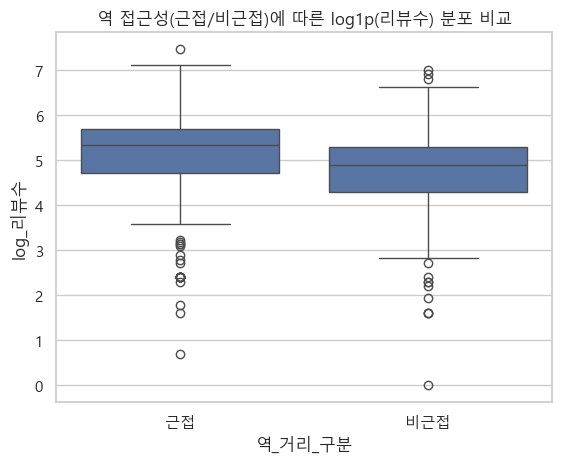

In [29]:
# 3.2 범주형 변수 vs 성과 비교 (박스플롯)
sns.boxplot(
    data=최종_입지_병합,
    x="역_거리_구분",
    y="log_리뷰수"
)
plt.title("역 접근성(근접/비근접)에 따른 log1p(리뷰수) 분포 비교") # 역 근접 여부에 따른 성과 차이
plt.show()

# 역 접근성(근접/비근접)에 따른 성과 분포 차이 시각적 확인

### ***해석***
#### **시각적 확인 포인트**
| 항목              | 설명                    | 관찰 포인트                                  |
| --------------- | --------------------- | --------------------------------------- |
| **중앙값(Median)** | 박스 안 굵은 선             | 근접·비근접 점포 간 log_리뷰수 중앙값 비교              |
| **사분위수(IQR)**   | 박스 위/아래 경계 (25%, 75%) | 박스 길이 → 분포 폭 확인                         |
| **최소·최대값과 이상치** | 수염(whisker)과 점        | 극단값 존재 여부, 한쪽 그룹에 이상치 집중 시 평균/중앙값 왜곡 가능 |

#### **관찰 결과**
| 지표  | 근접                | 비근접                 | 해석                         |
| --- | ----------------- | ------------------- | -------------------------- |
| 중앙값 | 5.2               | 4.9                 | 거의 차이 없음 → 평균 수준 차이 미미     |
| IQR | 4.6 ~ 5.7         | 4.3 ~ 5.6           | 분포 폭 유사 → 분산 수준도 비슷        |
| 이상치 | log_리뷰수 0~1, 7 이상 | log_리뷰수 0~1, 6.5 이상 | 일부 점포가 극단값 존재, 전체 패턴 왜곡 가능 |

#### **종합해석**
- 근접/비근접 점포 간 log_리뷰수 차이는 거의 없음
- 중앙값과 분포 폭 모두 유사, 일부 이상치 존재